In [1]:
import numpy as np
from qutip import *
from scipy.optimize import minimize
import h5py
import matplotlib.pyplot as plt
import sys
import pickle
import time

/Users/jwbaskerv/Envs/pblt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Parameters

For n qubits, we need n(n-1) + 2n arbitary rotation gates, with 3 parameters each.

https://arxiv.org/abs/1612.02806

In [2]:
# functions for pickling (saving) arbitrary objects
# necessary because HDFsav5 cannot easily save objects such as dictionaries
def save_obj(obj, name):
    with open('pickle/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### QuTip Implementation

#### QuTip Helper Functions

In [3]:
# apply given single-qubit gate to any qubit in system of n qubits
def tgtgate(n, gate, tgt):
    lst = [qeye(2) for _ in range(n)]
    lst[tgt] = gate
    return tensor(lst)

# create tensored identity in hilbert space of n qubits
def tenseye(n):
    return tensor([qeye(2) for _ in range(n)])

# create operator from product of all gates in a circuit
def gate_prod(n, gates):
    prod = tenseye(n)
    for gate in gates:
        prod = prod * gate
    return prod

#### Arbitrary Rotation Gates (single-qubit and controlled)

In [4]:
# https://arxiv.org/abs/quant-ph/9503016

# ROT = Rz(alpha) * Ry(theta) * Rz(beta)
def rot(n, params, tgt):
    alpha, theta, beta = params
    return rz(alpha, n, tgt)*ry(theta, n, tgt)*rz(beta, n, tgt)

# CROT = A * CNOT * B * CNOT * C
# A = Rz(alpha)*Ry(theta / 2)
# B = Ry(-theta / 2) * Rz(-(alpha + beta) / 2)
# C = Rz((beta - alpha) / 2)
def ctrl_rot(n, params, ctrl, tgt):
    alpha, theta, beta = params
    A = rz(alpha, n, tgt) * ry(theta / 2.0, n, tgt)
    B = ry(-theta / 2.0, n, tgt) * rz(-(alpha + beta) / 2.0, n, tgt)
    C = rz((beta - alpha) / 2.0, n, tgt)
    
    # these should ALWAYS be true, no matter the values of parameters
#     if not (A*B*C == tenseye(n)):
#         tb = sys.exc_info()[2]
#         raise RuntimeError("ABC not equal to identity").with_traceback(tb)
#     elif not (A*tgtgate(n, sigmax(), tgt)*B*tgtgate(n, sigmax(), tgt)*C == rot(n, params, tgt)):
#         tb = sys.exc_info()[2]
#         raise RuntimeError("AXBXC not equal to correct rotation gate").with_traceback(tb)
    
    return A * cnot(n, ctrl, tgt) * B * cnot(n, ctrl, tgt) * C

#### Parameter Manipulation

In [5]:
def init_consts(n_qubits):
    n_gates = n_qubits * (n_qubits - 1) + 2 * n_qubits
    n_params = n_gates * 3
    return n_gates, n_params

def init_params(n_params, method=np.zeros):
    return method(n_params)

def split_params(n_qs, params):
    return (params[:3*n_qs].reshape(n_qs, 3),
            params[3*n_qs:-3*n_qs].reshape(n_qs, n_qs-1, 3),
            params[-3*n_qs:].reshape(n_qs, 3))

def recombine_params(first, mid, last):
    return np.concatenate((first.flatten(), mid.flatten(), last.flatten()))

#### Circuit
The circuit outlined in red below is the unitary gate for encoding (in this case, for 4 qubit inputs).
![arbitrary_rotation_gate_circuit](https://image.ibb.co/ji9XBc/unit_cell_arb_rot.png)

In [6]:
# # create circuit from parameters
# def get_circuit_gates(num_gates, params):
#     gates = np.array([tenseye(4) for _ in range(num_gates)])

#     # R1 - R4
#     for gate_num in range(0, 4):
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = arb_rot(n, alpha, theta, beta, gate_num - 0)

#     # R5 - R7 controlled by qubit 0
#     for gate_num in range(4, 7):
#         control = 0
#         targets = [1, 2, 3]
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = ctrl_rot(n, alpha, theta, beta, control, targets[gate_num - 4])

#     # R8 - R10 controlled by qubit 1
#     for gate_num in range(7, 10):
#         control = 1
#         targets = [0, 2, 3]
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = ctrl_rot(n, alpha, theta, beta, control, targets[gate_num - 7])

#     # R11 - R13 controlled by qubit 2
#     for gate_num in range(10, 13):
#         control = 2
#         targets = [0, 1, 3]
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = ctrl_rot(n, alpha, theta, beta, control, targets[gate_num - 10])

#     # R14 - R16 controlled by qubit 3
#     for gate_num in range(13, 16):
#         control = 3
#         targets = [0, 1, 2]
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = ctrl_rot(n, alpha, theta, beta, control, targets[gate_num - 13])

#     # R17 - R20
#     for gate_num in range(16, 20):
#         alpha, theta, beta = params[gate_num]
#         gates[gate_num] = arb_rot(n, alpha, theta, beta, gate_num - 16)

#     return gates

In [7]:
# gate_product = gate_prod(n, gates)
# gate_product

#### Circuit Implementation

In [8]:
# The n rotation gates (one on each qubit) that happen at the start and end.
def wrapper_gate(n, param_sets):
    if len(param_sets) != n:
        raise ValueError('number of sets of params should correspond to number of gates')
    gates = []
    for tgt, rot_params in enumerate(param_sets):
        gates.append(rot(n, rot_params, tgt))
    return gate_prod(n, gates)

# The n-1 gates in each "blue box" (set of controlled rotation gates)
def blue_box_gate(n, params, ctrl):
    p_index = 0
    gates = []
    for tgt in range(n):
        #print (tgt, ctrl)
        if tgt == ctrl:
            continue
        rot_params = params[p_index]
        p_index += 1
        gates.append(ctrl_rot(n, rot_params, ctrl, tgt))
    return gate_prod(n, gates)

# The circuit as a whole -- front wrapper, blue boxes, back wrapper
def create_circuit_gate(n, all_params):
    params = np.array(all_params)
    gates = []
    
    # split parameters
    f, m, b = split_params(n, params)
    
    # front wrapper
    gates.append(wrapper_gate(n, f))
    
    # blue boxes
    for i in range(n):
        gates.append(blue_box_gate(n, m[i], i))
    
    # back wrapper
    gates.append(wrapper_gate(n, b))
    
    return gate_prod(n, gates)

In [9]:
# # given input state and output state, returns estimated fidelity
# #     we can cast to integer because this is the norm squared
# #     there's no longer any complex component
# def overlap(inp, oup):
#     ol = inp.overlap(oup)
#     return int(ol * ol.conj())
# v_overlap = np.vectorize(overlap)

# # return objective to minimize for scipy optimizers
# #     given N data points
# #     params: parameters to tune
# #     args: [n, ...bunch_of_instates_to_train_on...]
# def obj_func(params, *args):
#     n = args[0]
#     in_states = args[1:]
    
#     # create encoding operator from parameters of the rotation gates
#     encoding_op = create_circuit_gate(n, params)
    
#     # apply encoding circuit to all training data
#     # (should probably split this up into epochs)
#     out_states = encoding_op * in_states
    
#     overlaps = 1 - v_overlap(in_states, out_states)
#     return sum(overlaps)

In [10]:
# # create qubit from a rand float
# def qubit(a, b):    
#     # random phase shifts
#     if np.random.rand() <= 0.5:
#         a = a * 1.0j
#     if np.random.rand() <= 0.5:
#         b = b * 1.0j
#     return Qobj([[a],[b]]).unit()
# v_qubit = np.vectorize(qubit)

# def gen_data(n_orig, n_enc, data_count=100):
#     if n_orig < n_enc:
#         raise ValueError, ""
#     assert(n_orig >= n_enc)
#     data = []
    
#     # choose which qubits to exclude
#     excluded = np.random.choice(range(n_orig), size=(n_orig - n_enc), replace=False)
    
#     # set shape matrix
#     shape = [2]*n_orig
    
#     # generate data
#     for _ in range(data_count):
#         qubits = v_qubit(2 * np.random.random(n_orig) - 1, 2 * np.random.random(n_orig) - 1)
#         qubits[excluded] = basis(2,0)
#         data.append((tensor(qubits)).unit())
        
#     return np.array(data)

In [11]:
# data = gen_data(2,1,data_count=1000)
# initial_params = init_params(num_params)
# data[:5]
# # minimize(obj_func, initial_params, method='Nelder-Mead')

In [12]:
# U = sigmax()
# instates = np.array([Qobj([[0],[1]]), Qobj([[1],[0]])])
# outstates = U*instates
# sum(1-v_overlap(instates, outstates))

## Density Matrix Overview:

In order to understand how the cost function is computed for the autoencoder, we will need to describe our system in terms of density matricies. Density matrices are useful because they describe ensemble behavior of quantum experiments - which are often the result of imperfect quantum manipulations.

To this point in ES170 we have dealt only with pure states - where the quantum state of the system inputs and outputs can be described by a single state vector.

In practice we can have states which are a probablilistic ensemble of pure states. Note that this is fundamentally different from a superposition. We will explore describe this distinction explicitly below. Density matrices are a useful tool for describing this more general class of ensemble states.

The following examples will illustrate the mechanics of density matrices.

For a pure state, $|\psi>$ the density matrix (sometimes called the density operator) is given by the following:

$\rho = |\psi><\psi|$

For a single bit system, expressed in the $\{|0>,|1>\}$ basis, the density matrix elements are thus:

$\rho_{11} = <0|\rho|0>$

$\rho_{12} = <0|\rho|1>$

$\rho_{21} = <1|\rho|0>$

$\rho_{12} = <1|\rho|1>$

With some simple dirac manipulation, we can see that the entries of the density matrix are probabilities. For example, $\rho_{11}$ is the probability of measuring $|\psi>$ in state zero.

As an example, we construct the density matrix for basis states:

In [13]:
# Basis state 0 
q0 = basis(2,0)

rho = q0*q0.dag()

rho

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [14]:
# note the following function also works
ket2dm(q0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [15]:
# For basis state 1
q1 = basis(2,1)

ket2dm(q1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

These pure, orthogonal basis states are equivalent to fock (photon number) states, and qutip has a built in function:

In [16]:
fock_dm(2,1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

Nice! We can simply read the probability of the system being in state zero or one by looking at the diagonal entries. What happens for a superpostion?

In [17]:
# equal superposition state
q = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))

ket2dm(q)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

For a superposition we have off diagonal terms! These off-diagonal terms have important physical meaning (in some cases can be interpreted as coherence). For now we'll ignore that.

The most important property is that for a pure state, the trace (sum of diagonals) of the density matrix is 1. This is related exactly to the normalized nature of a pure state.

In [18]:
ket2dm(q).tr()

0.9999999999999998

Now let's consider a statistical ensemble of pure states. For example, imagine we prepare a _set_ of qubits, half in state zero and half in state one. We could measure these qubits in sequence and build up a statistical interpretation of the initial state. 

This statistical outcome can be expressed as an ensemble state:

$|\Psi> = \frac{1}{2}|0> + \frac{1}{2}|1>$

For which the density matrix is defined:

$\rho = \sum\limits_{i}{p_i|\psi_i><\psi_i|}$

In [19]:
q = 1/2*basis(2,0) + 1/2*basis(2,1)

ket2dm(q)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.25 0.25]
 [0.25 0.25]]

### Probabilities of Pure and Mixed States:
How can we tell this is not a pure state? By looking at the trace of the density matrix. 

$\text{Tr}[\rho] < 1 \implies \text{Mixed State}$


The trace in this case is less than 1, indicating a statistical mixture. Actually, in this case we have what is a maximally mixed state:

$\text{Tr}[\rho_{max}] = 1/D$ where $D$ is the dimensionality of the system. In the case of qubits D = 2.

In [20]:
ket2dm(q).tr()

0.5

### Transformation of Density Matrices:

Note that density matrices undergo unitary transformation as follows:

$\rho = |\psi><\psi|$

$\rho' = |\psi'><\psi'|$

$|\psi'> = U|\psi>$ and $ <\psi'| =  <\psi|U^{\dagger}$

$ \implies \rho' = U|\psi><\psi|U^{\dagger}$

$ \implies \rho' = U\rho U^{\dagger}$

## The Cost Fuction:

Consider an input ensemble state $\{p_i,|\psi_i\rangle\}$, where $p_i$ are ensemble probabilities of each pure state, $|\psi_i\rangle$. Note that ${|\psi_i\rangle}$ are  not necessarily orthonormal. The density matrix is given by the following:

$\rho = \sum\limits_{i}{p_i|\psi_i\rangle\langle\psi_i|}$

e.g. if our state turns out to be pure for a pure state (e.g. $|\psi_0\rangle$), the ensemble set reduces to $\{1,|\psi_0\rangle\}$.

The autoencoder cost function is given by:

$C_2(q) = \sum\limits_{i}{p_i \times F(Tr_{A}[U^{q}|\psi_i\rangle\langle\psi_i|_{AB}(U^{q})^{\dagger}],|a\rangle_{B})}$

$C_2(q) = {F(Tr_{A}[U^{q}\rho_{AB}(U^{q})^{\dagger}],\rho_{out,B})}$

where $q$ is the set of parameters used to form the arbitrary transformation matrix $U^q$, and $\rho_{out,B}$ our trash state. Performing the partial trace over A, reduces the n+k dimensional density matrix to a k dimensional density matrix corresponding only to the trash state subspace.

Here is a translation of the math into code: 
* Input state can be, in general, an ensemble state decomposed as $\{p_i,|\psi_i\rangle\}$
* Represent this set of states as a density matrix
* Apply the autoencoder transform U to the state, with parameters q
* Take a partial trace over the trash subset of the transformed density matrix to recover the trash state density matrix
* Using a fidelity function, compare the trash state density matrix to the ancillary state density matrix (in our case zeros)

We can take the output of the cost function and feedback into the minimizer to find the encoding transformation.

Qutip Partial Trace: http://qutip.org/docs/3.1.0/guide/guide-tensor.html
* example of partial trace function
* ket to density matrix function

Qutip Fidelity Function: http://qutip.org/docs/3.1.0/apidoc/functions.html
* Search fidelity - computes the fidelity of two density matrices

In [21]:
# Cost Function Testing:
p = [0.5,0.5]
pure = [1,1]
psi = [basis(2,0),basis(2,1)]
psi_pure = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
psi_mixed = 1/2*(basis(2,0)+basis(2,1))

C1 = np.sum(fidelity(ket2dm(psi_pure),ket2dm(psi_pure)))
print(C1)

C1 = [p[i]*fidelity(ket2dm(psi[i]),ket2dm(psi_mixed)) for i in range(len(psi))]
print(C1)

print(1/2*ket2dm(psi[0])+1/2*ket2dm(psi[1]))

print(ket2dm(1/2*psi[0]+1/2*psi[1]))

0.9999999999999996
[0.25, 0.25]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.25 0.25]
 [0.25 0.25]]


In [22]:
# Cost function implementation from the paper:
n = 5
k = 2

trashdm = ket2dm(tensor([basis(2,0) for _ in range(k)]))

# This version is broken down in terms of basis vectors and ensemble probabilities:
#C2 = np.sum([p_set[i] * fidelity((U*ket2dm(psi_set[i])*U.dag()).ptrace(np.arange(n,n+k)),trashdm) for i in range(len(psi_set))])

# # This version composes the input density matrix from the ensemble set of input states, then performs the transform:
# inputdm = np.sum([p_set[i] * ket2dm(psi_set[i]) for i in range(len(psi_set))])
# C2 = fidelity((U*inputdm*U.dag()).ptrace(np.arange(n,n+k)),trashdm)

## Hydrogen Wavefunction Training Set:

In the infamous article, the authors test the autoencoder with a set of ground state wavefunctions of molecular hydrogen. The autoencoder is trained with a subset of 6 ground state wavefunctions at different radial H-H distances, and then the encoder is tested on states at other radii. The Hamiltonian for molecular hydrogen can be solved numerically (classically), which would give us a benchmark for the performance of the autoencoder. We are considering to also implement this set of test states - though it is proving to be challenging!

The Hamiltonian for molecular hydrogen, under the Born-Oppenheimer non-relativistic approximation is given by:

$H = h_{nuc} +\sum\limits_{pq}h_{pq}a_p^{\dagger}a_q^{\dagger} + \frac{1}{2}\sum\limits_{pqrs}h_{pqrs}a_p^{\dagger}a_q^{\dagger}a_r a_s$

There are a few terms here: a nuclear term $h_{nuc}$, a single electron term, and a two electron term, with corresponding electron integrals $h_{pq}$ and $h_{pqrs}$. These terms express the probabilities of electrons occupying different molecular orbitals (e.g. $a_p^{\dagger}$ creates an electron in spin-orbital $p$).

As in the case of qubits, we are free to choose the basis of this Hamiltonian to be whatever we like. In quantum chemistry, we choose a basis which corresponds to a specific set of orthogonal electron orbitals. Often, this basis is selected with the convenience of calculation in mind. For example, the STO-6G hydrogen minimal basis set is one such basis set which is optimized for numerical approximation (the details of which we will perhaps need to explore later).

Furthermore, in order to map this Hamiltonian to a quantum computer, we need to decompose it as a set of pauli rotation operations on single qubits. This is done by either the Bravi-Kitaev (BK) or Jordan-Wigner (JW) transformations. The result of the JW transformed Hamiltonian in the STO-6G basis is as follows:

$H = c_0 I
+ c_1 (Z_0 + Z_1) 
+ c_2 (Z_2 + Z_3)
+ c_3 (Z_0 Z_1)
+ c_4 (Z_0 Z_2 + Z_1 Z_3)
+ c_5 (Z_1 Z_2 + Z_0 Z_3)
+ c_6 (Z_2 Z_3)
+ c_7 (Y_0 X_1 X_2 Y_3 - X_0 X_1 Y_2 Y_3 - Y_0 Y_1 X_2 X_3 + X_0 Y_1 Y_2 X_3)$

Where $X_n, Y_n, Z_n$ are a pauli matrices acting on the $n$th qubit, and $c_n$ are coefficients which depend on the radial H-H distance.

The Hamiltonian is implemented in qutip below: 

In [23]:
# # Reproducing the test set based on the STO-6G minimum basis set of hydrogen
# # From paper:

# def makepaulin(N,P):
#     PN = []
#     for n in range(N):
#         tmp = [qeye(2) for _ in range(N)]
#         tmp[n] = P
#         Pn = tensor(tmp)
#         PN.append(Pn)
#     return PN

# N=4
# X = makepaulin(N,sigmax())
# Y = makepaulin(N,sigmay())
# Z = makepaulin(N,sigmaz())
# IN = tensor([qeye(2) for _ in range(N)])

# # setting all coefficients to 1
# [c0,c1,c2,c3,c4,c5,c6,c7] = [1,1,1,1,1,1,1,1]
    
# H = (c0*IN + 
# c1*(Z[0]+Z[1]) + 
# c2*(Z[2]+Z[3]) + 
# c3*Z[0]*Z[1] + 
# c4*(Z[0]*Z[2] + Z[1]*Z[3]) + 
# c5*(Z[1]*Z[2]+Z[0]*Z[3]) + 
# c6*(Z[2]*Z[3]) + 
# c7*(Y[0]*X[1]*X[2]*Y[3] - X[0]*X[1]*Y[2]*Y[3] - Y[0]*Y[1]*X[2]*X[3] + X[0]*Y[1]*Y[2]*X[3]))

# print(H)

In order to advance from here, we need to compute the coefficients of this Hamiltonian (which depend on radial distance between H atoms), and solve the Schroedinger equation to find ground state energies (in Hartrees) at different distances to form the set of training states. 

I think this requires an optimized solver of Schroedinger's equation, which is beyond probably beyond the scope of this project to implement. We could also use a variational quantum eigensolver, but that requires it's own detailed investigation as well.

One potential workaround could be to use PyQuante - a python library which is built to perform these kinds of caluculations (STO-6G hydrogen minimal basis set approximation). It's a dated python module, and thus far I've had version control issues getting it to integrate here.

I have requested a chemsitry textbook from the library which might lay out the calculation in more detail for us.

Until then we might need to think of a simpler test set or reach out to Zapata.

### Using Data from OpenFermion!!
the bond lengths are stored in `bond_lengths.hdf5`

each bond-length has a hamiltonian stored at `hamiltonians/sto-3g.<bond-length>.hdf5`

In [24]:
# get the list of bond lengths for which we precomputed hamiltonians
with h5py.File("bond_lengths.hdf5", "r") as f:
    try:
        dset = f['bond_lengths']
        bond_lengths = np.zeros(dset.shape)
        dset.read_direct(bond_lengths)
    except KeyError:
        print("subgroup `bond_lengths` not in `bond_lengths.hdf5` data")
        
if type(bond_lengths) == type(None):
    print("failure to read bond lengths")
else:
    bond_lengths = np.round(bond_lengths, 2)

In [25]:
# list of hamiltonians
hamiltonians = []

for bond_length in bond_lengths:
    hamiltonian = None
    
    # read hamiltonian from appropriate file
    with h5py.File("hamiltonians/sto-3g.{}.hdf5".format(round(bond_length, 2)), 'r') as f:
        try:
            dset = f['hamiltonian']
            hamiltonian = dset[()]
        except KeyError:
            print("subgroup `hamiltonian` not in `hamiltonians/{}` data".format(round(bond_length, 2)))
    
    if type(hamiltonian) == type(None):
        print("failure to read hamiltonian for bond length {}".format(round(bond_length, 2)))
        continue
    
    # add hamiltonian to dictionary of hamiltonians
    hamiltonians.append(Qobj(hamiltonian, dims=[[2,2,2,2],[2,2,2,2]]))
    
hamiltonians = np.array(hamiltonians)

In [26]:
def get_groundstate(hamiltonian):
    return hamiltonian.groundstate()
groundstatize = np.vectorize(get_groundstate)

In [27]:
# compute groundstates of molecular hamiltonians to use as training and testing data
groundenergies, groundstates = groundstatize(hamiltonians)

(0, 2.5)

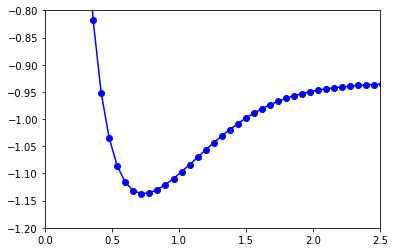

In [28]:
# plot hydrogen atom bond-length vs. ground-state energies
# red points are those states selected for training, everything else is for testing
plt.plot(bond_lengths, groundenergies, 'ob-')
#plt.plot(bond_lengths[training_indices], groundenergies[training_indices], 'or')
plt.ylim([-1.2, -0.8])
plt.xlim([0, 2.5])

### Train the Autoencoder!

In [29]:
# this probably exists in sklearn

def train_test_split(data, train_proportion, train_is=None):
    """
    Divide data into training and test sets, using specific indices if given
    """
    train_sz = int(np.round(len(data) * train_proportion))
    training_indices, testing_indicies = [], []
    
    # use provided training indices, then fill in the rest
    if train_is is not None:
        training_indices = np.concatenate(
            (train_is, np.random.choice([i for i in np.arange(len(data)) if i not in train_is], 
                                        train_sz - len(train_is), replace=False)))
    else:
        training_indices = np.random.choice(np.arange(len(data)), train_sz, replace=False)
    
    testing_indicies = np.array([i for i in range(len(data)) if i not in training_indices])
    return data[training_indices], data[testing_indicies]

In [30]:
def gen_dmify():
    return np.vectorize(ket2dm)

def gen_encodify(U):
    return np.vectorize(lambda dm: U*dm*U.dag())

def gen_ptracify(sel):
    return np.vectorize(lambda dm: dm.ptrace(sel))

def gen_fidelify(tr_dm):
    return np.vectorize(lambda dm: fidelity(dm, tr_dm))

# Cost function implementation from the paper:
def cost(params, psi_set, n, k, sel, debug=False):
    n_states = len(psi_set)
    trashdm = ket2dm(tensor([basis(2,0) for _ in range(k)]))

    U = create_circuit_gate(n + k, params)

    dmify = gen_dmify()
    encodify = gen_encodify(U)
    ptracify = gen_ptracify(sel)
    fidelify = gen_fidelify(trashdm)

    # turn each state in the training set into a density matrix
    dms = dmify(psi_set)
    
    # encode dms
    encoded_dms = encodify(dms)

    # Apply the encode/decode transformation and get the partial trace
    ptrace_dms = ptracify(encoded_dms)  

    # get fidelities
    fidelities = fidelify(ptrace_dms)
    
    if debug:
        print("parameters:", params)
        print("compression dimension ; trash dimension:", n, ";", k)
        print("partial trace (trash) qubits:", sel)
        print("number of input states:", n_states)
        matrix_histogram(ptrace_dms[n_states - 1])
        plt.show()
        print("fidelities:", fidelities)
        print ("cost", 1 - np.sum(fidelities) / n_states)
    
    # compute cost, with probability weights equal
    # print ("cost", 1 - np.sum(fidelities) / n_states)
    return 1 - (np.sum(fidelities) / n_states)

In [31]:
class CostInfo():
    """
    Makes use of the 'cost' function as a method of a class that keeps track of
    the cost at each iteration
    """
    def __init__(self):
        self.costs = []
        
    def class_cost(self, params, psi_set, n, k, sel, debug=False):
        cost_res = cost(params, psi_set, n, k, sel, debug)
        self.costs.append(cost_res)
        return cost_res

In [32]:
# calculate average fidelity over set of input states
def avg_cost(c, num_states):
    return c / num_states

In [33]:
n_gates, n_params = init_consts(4)

# same training states as those in the paper
lens = [7, 11, 16, 24, 33, 41]
train_set = np.array(groundstates)[lens]
test_set = np.array(groundstates)[[i for i in range(len(groundstates)) if i not in lens]]

In [35]:
method = 'L-BFGS-B'
iters = 1
sel = [0,2]

while True:
#for _ in range(1):
    try:
        # always initialize new class in the beginning to initialize empty cost array attribute
        ci = CostInfo()
        # initialize new random parameters for variability
        initial_params = init_params(n_params, lambda x: np.random.rand(x)*2*np.pi)
        
        print ("Iteration: {}".format(iters))

        # use the class method cost function so that costs are logged internally in the class
        res = minimize(ci.class_cost, initial_params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-03, 'ftol': 0.1})
        params = res['x']

        checkpoint1 = ci.costs.copy()
        print("Round 1 took {} iterations".format(len(checkpoint1)))

        res2 = minimize(ci.class_cost, params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-05, 'ftol': 0.01})
        params2 = res2['x']

        checkpoint2 = ci.costs.copy()
        print("Round 2 took {} iterations".format(len(checkpoint2) - len(checkpoint1)))
        
        # res3 = minimize(ci.class_cost, params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-07, 'ftol': 0.0001})
        res3 = minimize(ci.class_cost, params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-03, 'ftol': 0.000001})
        params3 = res3['x']
        
        checkpoint3 = ci.costs.copy()
        print("Round 3 took {} iterations".format(len(checkpoint3) - len(checkpoint2)))
                
        # res4 = minimize(ci.class_cost, params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-08, 'ftol': 0.000001})
        # params4 = res4['x']
        
        # final_result = res4
        final_result = res3
        # save costs and selection as part of the result
        final_result["costs"] = ci.costs
        final_result["sel"] = sel
        
        # save results for later analysis
        save_obj(final_result, 'run2.{}-{}.{}'.format(2, 2, str(int(time.time()))[2:]))
        
        iters += 1
    except KeyboardInterrupt:
        sys.exit()

Iteration: 1
Round 1 took 183 iterations
Round 2 took 305 iterations
Round 3 took 2379 iterations
Iteration: 2
Round 1 took 183 iterations
Round 2 took 244 iterations
Round 3 took 3416 iterations
Iteration: 3
Round 1 took 122 iterations
Round 2 took 488 iterations
Round 3 took 1891 iterations
Iteration: 4
Round 1 took 183 iterations
Round 2 took 366 iterations
Round 3 took 2013 iterations
Iteration: 5
Round 1 took 122 iterations
Round 2 took 488 iterations
Round 3 took 2257 iterations
Iteration: 6
Round 1 took 183 iterations
Round 2 took 427 iterations
Round 3 took 2257 iterations
Iteration: 7
Round 1 took 122 iterations
Round 2 took 488 iterations
Round 3 took 2867 iterations
Iteration: 8
Round 1 took 305 iterations
Round 2 took 366 iterations
Round 3 took 1708 iterations
Iteration: 9
Round 1 took 183 iterations
Round 2 took 305 iterations
Round 3 took 2623 iterations
Iteration: 10
Round 1 took 305 iterations
Round 2 took 244 iterations
Round 3 took 2440 iterations
Iteration: 11
Round

SystemExit: 

/Users/jwbaskerv/Envs/pblt/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
costs = final_result['costs']

In [37]:
costs[-1]

2.917697415893983e-07

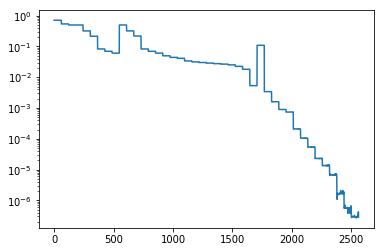

In [38]:
# graph of cost over each iteration
plt.plot(final_result["costs"])
plt.semilogy()
plt.show()

parameters: [3.37695435e-01 6.28186787e+00 1.26822662e+00 4.04907848e+00
 9.37934986e-01 4.27566718e+00 1.29504703e+00 3.14122588e+00
 4.62331527e+00 4.83577242e+00 3.82815271e+00 4.70130081e+00
 3.68617446e+00 6.72281923e+00 1.16583229e+00 1.89636959e+00
 2.73377600e+00 6.61439931e+00 2.68590317e+00 5.59312956e+00
 7.06539221e+00 7.45835728e-01 6.28143535e+00 2.39171560e+00
 4.23305466e-01 7.42915656e-04 3.41511105e+00 4.71307551e+00
 4.80627809e+00 4.30666912e+00 5.17680957e+00 2.63189874e+00
 4.23257985e+00 4.12605098e+00 7.75718911e+00 1.88188265e+00
 5.94090885e+00 5.87060396e+00 5.13431053e+00 5.06816575e+00
 3.13906288e+00 9.64333527e-01 8.90475618e-01 1.15967875e+00
 5.95828202e+00 3.37819252e+00 3.13998245e+00 2.49806522e+00
 2.04989939e+00 6.79197634e+00 9.43865592e-03 7.30285365e+00
 4.82659916e+00 2.62097413e+00 3.00397821e+00 3.14091792e+00
 4.24510123e+00 2.37009328e+00 0.00000000e+00 6.58065340e+00]
compression dimension ; trash dimension: 2 ; 2
partial trace (trash) qub

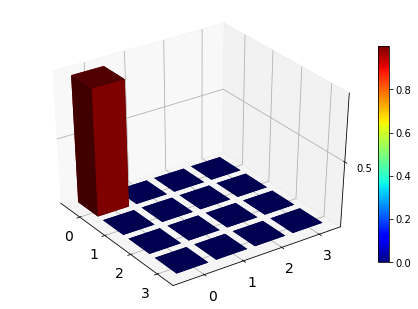

fidelities: [0.99999969 0.99999969 0.99999969 0.99999969 0.9999997  0.9999997
 0.9999997  0.9999997  0.99999971 0.99999971 0.99999972 0.99999972
 0.99999972 0.99999973 0.99999973 0.99999974 0.99999974 0.99999974
 0.99999974 0.99999974 0.99999974 0.99999974 0.99999974 0.99999973
 0.99999973 0.99999973 0.99999972 0.99999971 0.99999971 0.9999997
 0.99999969 0.99999969 0.99999968 0.99999968 0.99999967 0.99999967
 0.99999966 0.99999965 0.99999965 0.99999965 0.99999964 0.99999964
 0.99999964 0.99999964]
cost 3.0040564213962284e-07
average cost over test set: 6.827400957718701e-09


In [39]:
# results on test set of data
final_params = final_result['x']
final_sel = final_result['sel']
print("average cost over test set:", avg_cost(cost(final_params, test_set, 2, 2, final_sel, debug=True), len(test_set)))

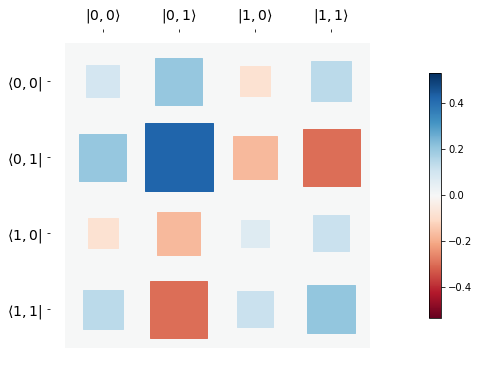

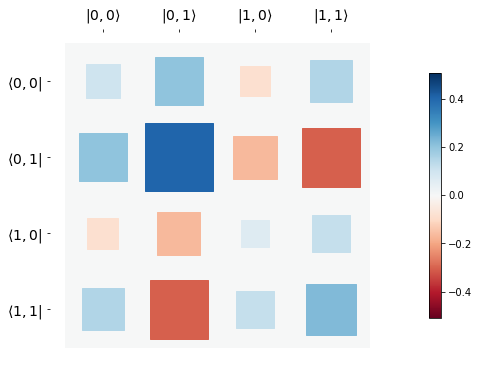

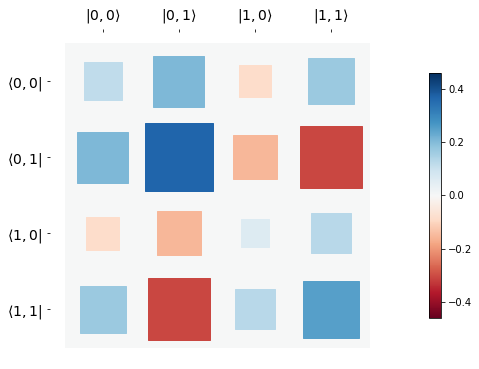

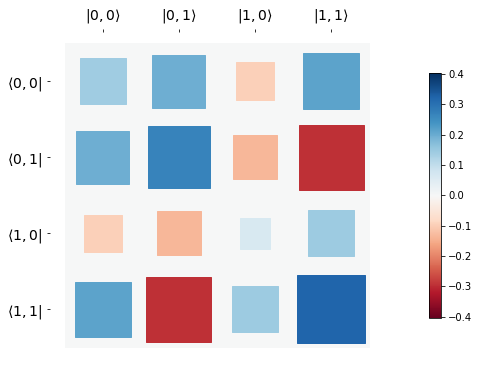

In [40]:
U = create_circuit_gate(n=4, all_params=final_params)
for i in range(4):
    dm = U*ket2dm(train_set[i])*U.dag()
    hinton(dm.ptrace([j for j in range(4) if j not in final_sel]))